In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import confusion_matrix

from scipy.optimize import linear_sum_assignment

# Load dataset

In [2]:
df = pd.read_csv("../data/heart_disease.csv")
X = df.drop("num", axis=1)
y = df["num"]
df

,PC1,PC2,PC4,PC5,PC6,PC7,PC11,num
0,0.675205,0.344930,-0.087400,-0.438102,1.117363,-0.144715,-0.052244,0.0
1,3.544619,0.506039,-0.653609,0.713136,-1.170823,0.391445,0.053414,2.0
2,2.386927,-1.237065,-0.018786,0.465064,0.576870,-0.705147,0.092074,1.0
3,-1.344182,-0.262477,2.743671,0.313740,1.221851,0.702343,-0.377414,0.0
4,-1.755805,-0.296602,0.764861,0.245258,0.185786,0.279775,0.480802,0.0
...,...,...,...,...,...,...,...,...
298,-0.622619,-1.052430,0.766006,-1.006978,-0.233717,0.353068,0.633262,1.0
299,2.566185,-0.885424,-0.090710,1.081507,0.992006,-0.348138,0.261857,2.0
300,0.905604,-2.366826,-1.188388,-0.033922,-0.595107,-0.390816,0.015781,3.0
301,-0.777244,0.692779,-0.656726,0.792481,0.273470,-0.046283,0.921933,1.0


# K-Means Clustering

## Elbow Method to determine k

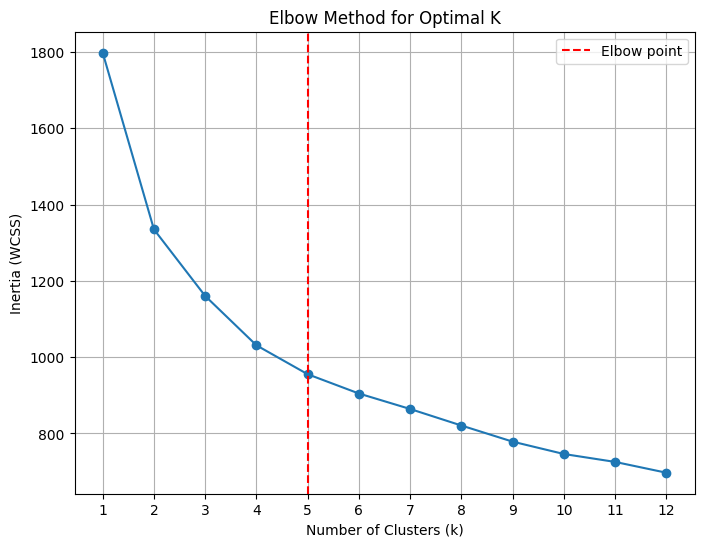

In [3]:
inertias = []
k_range = range(1, 13) # Test k from 1 to 12

# Fit KMeans for each k and store the inertia (WCSS)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=30, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.axvline(x=5, color='r', linestyle='--', label='Elbow point')
plt.legend()
plt.grid(True)
plt.show()

## Use optimal k=5

In [4]:
# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=5, random_state=30, n_init='auto')
kmeans.fit(X)
cluster_labels = kmeans.labels_

## Confusion Matrix
Since cluster labels are arbitrary (cluster 0 in K-Means might correspond to label 2 in the ground truth), the Hungarian algorithm (linear_sum_assignment) is used to rearrange the K-Means labels to match the true labels

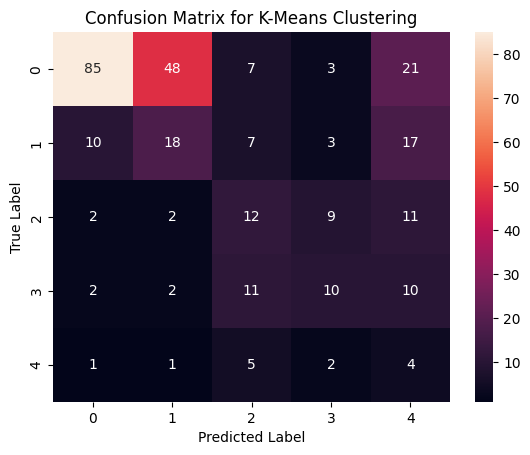

In [5]:
# calculate confusion matrix
cm = confusion_matrix(y, cluster_labels)
# use the Hungarian algorithm to find the best label mapping
row_ind, col_ind = linear_sum_assignment(-cm)
# create a new confusion matrix with the optimal label mapping
cm_optimal = cm[:, col_ind]

sns.heatmap(cm_optimal, annot=True, fmt='d')
plt.title('Confusion Matrix for K-Means Clustering')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Scatter Plot
Since cluster labels are arbitrary (cluster 0 in K-Means might correspond to label 2 in the ground truth), the Hungarian algorithm (linear_sum_assignment) is used to rearrange the K-Means labels to match the true labels

In [6]:
def align_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # create mapping from cluster -> true label
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # relabel predictions
    y_pred_aligned = np.array([mapping[label] for label in y_pred])
    return y_pred_aligned

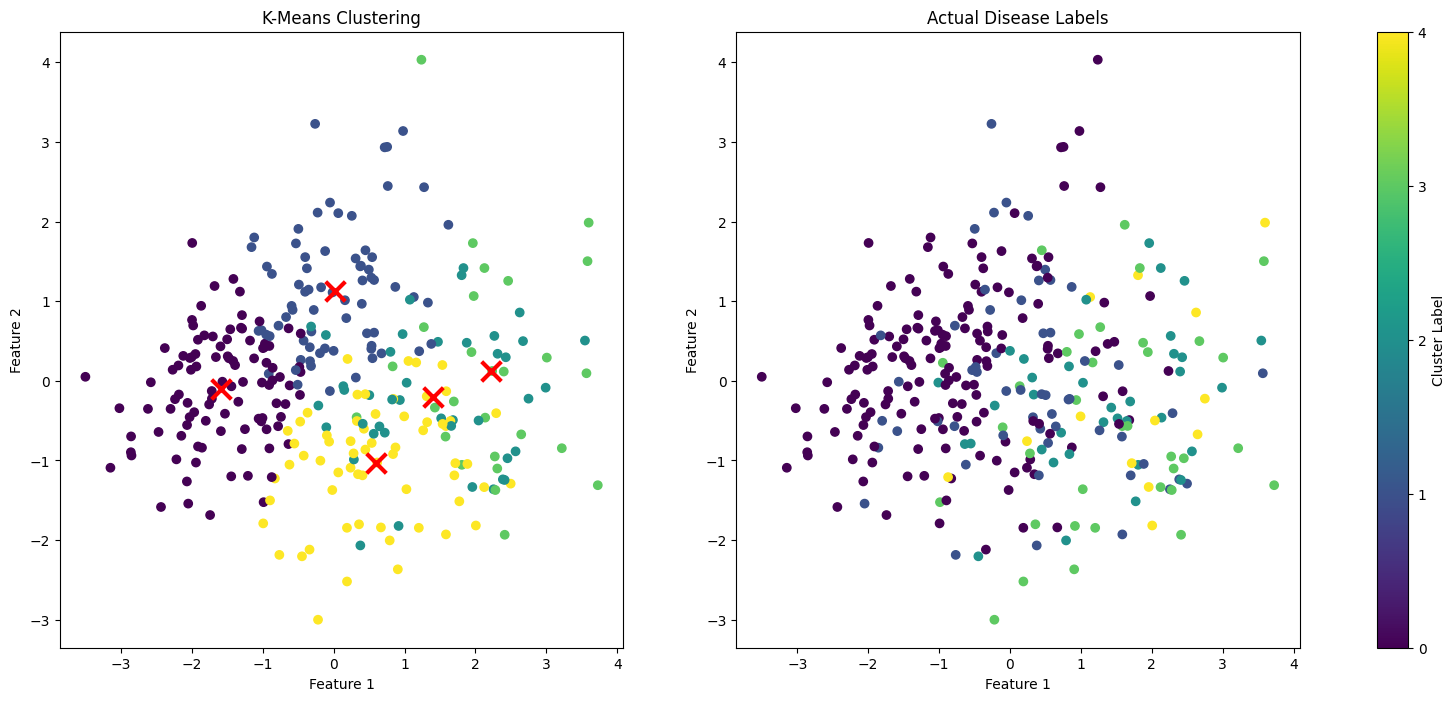

In [7]:
#plot clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot K-Means clusters
ax1.scatter(X['PC1'], X['PC2'], c=align_labels(y, kmeans.labels_), cmap='viridis')
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, c='red', linewidths=3)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Plot actual labels
ax2.scatter(X['PC1'], X['PC2'], c=y, cmap='viridis')
ax2.set_title('Actual Disease Labels')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

fig.colorbar(ax1.collections[0], ax=(ax1, ax2), label='Cluster Label', ticks=range(5))
plt.show()

# Hierarchical Clustering

## Perform clustering

In [8]:
#perform hierarchical clustering
linked = linkage(X, 'ward')

## Dendogram analysis

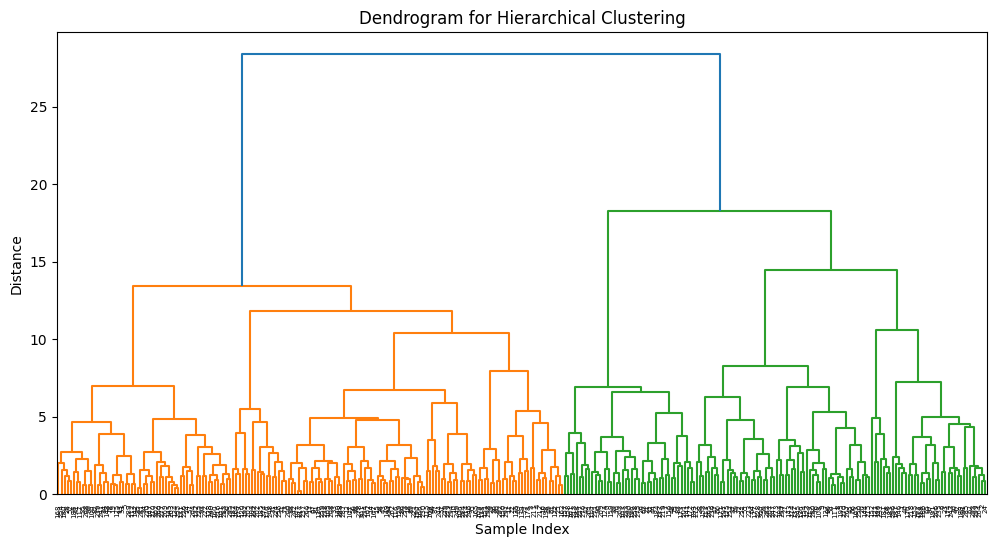

In [9]:
#plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## Scatter Plot

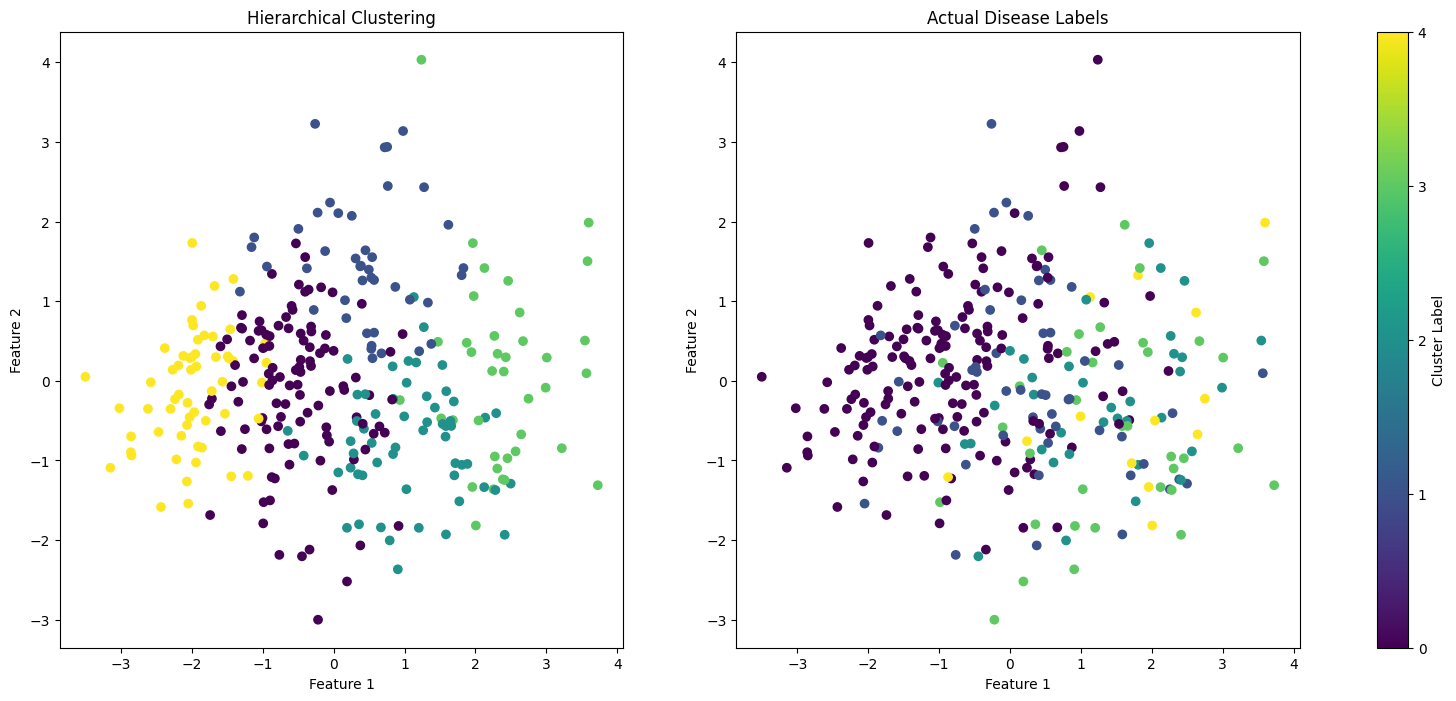

In [10]:
# Choose number of clusters (e.g., 5)
n_clusters = 5
hier_labels = fcluster(linked, n_clusters, criterion='maxclust')

# Align hierarchical clustering labels with true labels
hier_labels_aligned = align_labels(y, hier_labels)

#plot clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot heirarchical clustering results
ax1.scatter(X['PC1'], X['PC2'], c=hier_labels_aligned, cmap='viridis')
ax1.set_title('Hierarchical Clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Plot actual labels
ax2.scatter(X['PC1'], X['PC2'], c=y, cmap='viridis')
ax2.set_title('Actual Disease Labels')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

fig.colorbar(ax1.collections[0], ax=(ax1, ax2), label='Cluster Label', ticks=range(5))
plt.show()